# Read File

In [2]:
import networkx as nx
import random
from random import sample
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import scipy.stats

In [37]:
network = pd.read_csv('./Experimental_Network.csv')

In [38]:
graph = nx.read_edgelist('./Experimental_Network.csv' ,
                     create_using = nx.MultiGraph(), 
                     nodetype = str,  delimiter=',')

In [39]:
nx.info(graph)

'Name: \nType: MultiGraph\nNumber of nodes: 16165\nNumber of edges: 240541\nAverage degree:  29.7607'

# Cancer gene in Network

In [40]:
cancer = pd.read_csv('./Cancer_Table.csv')
print("Cancer Table Shape:", cancer.shape)
cancer.head()

Cancer Table Shape: (723, 21)


,Unnamed: 0,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,...,Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
0,0,A1CF,APOBEC1 complementation factor,29974.0,10:50799421-50885675,2,NaN,11.23,yes,NaN,...,NaN,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,ENSG00000148584
1,1,ABI1,abl-interactor 1,10006.0,10:26746593-26860935,1,Yes,12.10,yes,NaN,...,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,ENSG00000136754
2,2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25.0,9:130713946-130885683,1,Yes,34.12,yes,NaN,...,NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,ENSG00000097007
3,3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27.0,1:179099327-179229601,1,NaN,25.20,yes,NaN,...,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,ENSG00000143322
4,4,ACKR3,atypical chemokine receptor 3,57007.0,2:236569641-236582358,1,Yes,37.30,yes,NaN,...,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,ENSG00000144476


In [41]:
nn = set(graph.nodes)
cc = set(cancer['Synonyms'].tolist())
minus = nn.difference(cc)
graph.remove_nodes_from(minus)
og_d = nx.density(graph)

# Method 1: Random_edge 

In [13]:
def random_edge(graph, del_orig=True):
    '''
    Create a new random edge and delete one of its current edge if del_orig is True.
    :param graph: networkx graph
    :param del_orig: bool
    :return: networkx graph
    '''
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0]])

    if del_orig:
        # delete chosen edge
        graph.remove_edge(chosen_edge[0], chosen_edge[1])
        # add new edge
        graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])

    return graph

In [16]:
G = nx.read_edgelist('./Experimental_Network.csv' ,
                     create_using = nx.MultiGraph(), 
                     nodetype = str,  delimiter=',')
D1 = []
n = 0
start = time.time()
for i in range(1000):
    G1 = random_edge(G, del_orig=True)
    G_node= set(G1.nodes)
    G_nodes = list(G_node)
    tmp = sample(G_nodes, 701)
    G1 = G.subgraph(tmp)
    tmp1 = nx.density(G1)
    print("Density: %f" %tmp1)
    D1.append(tmp1)
    n += 1
    end = time.time()
    print("Progress: %d/1000 Time: %f" %(n, end - start))
print("Random Edge Model Density: \n%s\nElapsed Time: %fsecs" %(D1, end - start))

Density: 0.001198
Progress: 1/1000 Time: 70.791593
Density: 0.001883
Progress: 2/1000 Time: 140.417995
Density: 0.001806
Progress: 3/1000 Time: 211.367781
Density: 0.001712
Progress: 4/1000 Time: 283.308405
Density: 0.001394
Progress: 5/1000 Time: 358.867306
Density: 0.001333
Progress: 6/1000 Time: 461.318122
Density: 0.001944
Progress: 7/1000 Time: 535.909781


KeyboardInterrupt: 

# Method 2: Fixed Degree

In [17]:
"""Swap edges in a graph.
"""

import math
from networkx.utils import py_random_state

import networkx as nx

__all__ = ['double_edge_swap',
           'connected_double_edge_swap']

py_random_state(3)
def double_edge_swap(G, nswap=1, max_tries=100, seed=None):
    """Swap two edges in the graph while keeping the node degrees fixed.

    A double-edge swap removes two randomly chosen edges u-v and x-y
    and creates the new edges u-x and v-y::

     u--v            u  v
            becomes  |  |
     x--y            x  y

    If either the edge u-x or v-y already exist no swap is performed
    and another attempt is made to find a suitable edge pair.

    Parameters
    ----------
    G : graph
       An undirected graph

    nswap : integer (optional, default=1)
       Number of double-edge swaps to perform

    max_tries : integer (optional)
       Maximum number of attempts to swap edges

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : graph
       The graph after double edge swaps.

    Notes
    -----
    Does not enforce any connectivity constraints.

    The graph G is modified in place.
    """
    if G.is_directed():
        raise nx.NetworkXError(
            "double_edge_swap() not defined for directed graphs.")
    if nswap > max_tries:
        raise nx.NetworkXError("Number of swaps > number of tries allowed.")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    # Instead of choosing uniformly at random from a generated edge list,
    # this algorithm chooses nonuniformly from the set of nodes with
    # probability weighted by degree.
    n = 0
    swapcount = 0
    keys, degrees = zip(*G.degree())  # keys, degree
    cdf = nx.utils.cumulative_distribution(degrees)  # cdf of degree
    discrete_sequence = nx.utils.discrete_sequence
    while swapcount < nswap:
        #        if random.random() < 0.5: continue # trick to avoid periodicities?
        # pick two random edges without creating edge list
        # choose source node indices from discrete distribution
        (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
        if ui == xi:
            continue  # same source, skip
        u = keys[ui]  # convert index to label
        x = keys[xi]
        # choose target uniformly from neighbors
        v = seed.choice(list(G[u]))
        y = seed.choice(list(G[x]))
        if v == y:
            continue  # same target, skip
        if (x not in G[u]) and (y not in G[v]):  # don't create parallel edges
            G.add_edge(u, x)
            G.add_edge(v, y)
            G.remove_edge(u, v)
            G.remove_edge(x, y)
            swapcount += 1
        if n >= max_tries:
            e = (f'Maximum number of swap attempts ({n}) exceeded '
                 f'before desired swaps achieved ({nswap}).')
            raise nx.NetworkXAlgorithmError(e)
        n += 1
    return G


py_random_state(3)
def connected_double_edge_swap(G, nswap=1, _window_threshold=3, seed=None):
    """Attempts the specified number of double-edge swaps in the graph `G`.

    A double-edge swap removes two randomly chosen edges `(u, v)` and `(x,
    y)` and creates the new edges `(u, x)` and `(v, y)`::

     u--v            u  v
            becomes  |  |
     x--y            x  y

    If either `(u, x)` or `(v, y)` already exist, then no swap is performed
    so the actual number of swapped edges is always *at most* `nswap`.

    Parameters
    ----------
    G : graph
       An undirected graph

    nswap : integer (optional, default=1)
       Number of double-edge swaps to perform

    _window_threshold : integer

       The window size below which connectedness of the graph will be checked
       after each swap.

       The "window" in this function is a dynamically updated integer that
       represents the number of swap attempts to make before checking if the
       graph remains connected. It is an optimization used to decrease the
       running time of the algorithm in exchange for increased complexity of
       implementation.

       If the window size is below this threshold, then the algorithm checks
       after each swap if the graph remains connected by checking if there is a
       path joining the two nodes whose edge was just removed. If the window
       size is above this threshold, then the algorithm performs do all the
       swaps in the window and only then check if the graph is still connected.

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    int
       The number of successful swaps

    Raises
    ------

    NetworkXError

       If the input graph is not connected, or if the graph has fewer than four
       nodes.

    Notes
    -----

    The initial graph `G` must be connected, and the resulting graph is
    connected. The graph `G` is modified in place.

    References
    ----------
    .. [1] C. Gkantsidis and M. Mihail and E. Zegura,
           The Markov chain simulation method for generating connected
           power law random graphs, 2003.
           http://citeseer.ist.psu.edu/gkantsidis03markov.html
    """
    if not nx.is_connected(G):
        raise nx.NetworkXError("Graph not connected")
    if len(G) < 4:
        raise nx.NetworkXError("Graph has less than four nodes.")
    n = 0
    swapcount = 0
    deg = G.degree()
    # Label key for nodes
    dk = list(n for n, d in G.degree())
    cdf = nx.utils.cumulative_distribution(list(d for n, d in G.degree()))
    discrete_sequence = nx.utils.discrete_sequence
    window = 1
    while n < nswap:
        wcount = 0
        swapped = []
        # If the window is small, we just check each time whether the graph is
        # connected by checking if the nodes that were just separated are still
        # connected.
        if window < _window_threshold:
            # This Boolean keeps track of whether there was a failure or not.
            fail = False
            while wcount < window and n < nswap:
                # Pick two random edges without creating the edge list. Choose
                # source nodes from the discrete degree distribution.
                (ui, xi) = discrete_sequence(2, cdistribution=cdf, seed=seed)
                # If the source nodes are the same, skip this pair.
                if ui == xi:
                    continue
                # Convert an index to a node label.
                u = dk[ui]
                x = dk[xi]
                # Choose targets uniformly from neighbors.
                v = seed.choice(list(G.neighbors(u)))
                y = seed.choice(list(G.neighbors(x)))
                # If the target nodes are the same, skip this pair.
                if v == y:
                    continue
                if x not in G[u] and y not in G[v]:
                    G.remove_edge(u, v)
                    G.remove_edge(x, y)
                    G.add_edge(u, x)
                    G.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                # If G remains connected...
                if nx.has_path(G, u, v):
                    wcount += 1
                # Otherwise, undo the changes.
                else:
                    G.add_edge(u, v)
                    G.add_edge(x, y)
                    G.remove_edge(u, x)
                    G.remove_edge(v, y)
                    swapcount -= 1
                    fail = True
            # If one of the swaps failed, reduce the window size.
            if fail:
                window = int(math.ceil(window / 2))
            else:
                window += 1
        # If the window is large, then there is a good chance that a bunch of
        # swaps will work. It's quicker to do all those swaps first and then
        # check if the graph remains connected.
        else:
            while wcount < window and n < nswap:
                # Pick two random edges without creating the edge list. Choose
                # source nodes from the discrete degree distribution.
                (ui, xi) = nx.utils.discrete_sequence(2, cdistribution=cdf)
                # If the source nodes are the same, skip this pair.
                if ui == xi:
                    continue
                # Convert an index to a node label.
                u = dk[ui]
                x = dk[xi]
                # Choose targets uniformly from neighbors.
                v = seed.choice(list(G.neighbors(u)))
                y = seed.choice(list(G.neighbors(x)))
                # If the target nodes are the same, skip this pair.
                if v == y:
                    continue
                if x not in G[u] and y not in G[v]:
                    G.remove_edge(u, v)
                    G.remove_edge(x, y)
                    G.add_edge(u, x)
                    G.add_edge(v, y)
                    swapped.append((u, v, x, y))
                    swapcount += 1
                n += 1
                wcount += 1
            # If the graph remains connected, increase the window size.
            if nx.is_connected(G):
                window += 1
            # Otherwise, undo the changes from the previous window and decrease
            # the window size.
            else:
                while swapped:
                    (u, v, x, y) = swapped.pop()
                    G.add_edge(u, v)
                    G.add_edge(x, y)
                    G.remove_edge(u, x)
                    G.remove_edge(v, y)
                    swapcount -= 1
                window = int(math.ceil(window / 2))
    return swapcount



In [19]:
G = nx.read_edgelist('./Experimental_Network.csv' ,
                     create_using = nx.MultiGraph(), 
                     nodetype = str,  delimiter=',')
D2 = []
n = 0
start = time.time()
for n in range(1000):
    G1 = nx.double_edge_swap(G,nswap=2)
    G_node = set(G1)
    G_nodes = list(G_node)
    tmp = sample(G_nodes, 701)
    G1 = G.subgraph(tmp)
    tmp1 = nx.density(G1)
    print("Density: %f" %tmp1)
    D2.append(tmp1)
    n += 1
    end = time.time()
    print("Progress: %d/1000 Time: %f" %(n, end - start))
print("Random Edge Model Density: \n%s\nElapsed Time: %fsecs" %(D2, end - start))    

Density: 0.001369
Progress: 1/1000 Time: 0.234743
Density: 0.001838
Progress: 2/1000 Time: 0.344091
Density: 0.002576
Progress: 3/1000 Time: 0.531550
Density: 0.001528
Progress: 4/1000 Time: 0.648391
Density: 0.001781
Progress: 5/1000 Time: 0.742455
Density: 0.001891
Progress: 6/1000 Time: 0.866708
Density: 0.001773
Progress: 7/1000 Time: 0.974659
Density: 0.001606
Progress: 8/1000 Time: 1.068351
Density: 0.002515
Progress: 9/1000 Time: 1.176829
Density: 0.001777
Progress: 10/1000 Time: 1.292158
Density: 0.001541
Progress: 11/1000 Time: 1.398046
Density: 0.001557
Progress: 12/1000 Time: 1.495603
Density: 0.001170
Progress: 13/1000 Time: 1.614387
Density: 0.001626
Progress: 14/1000 Time: 1.721247
Density: 0.002209
Progress: 15/1000 Time: 1.828928
Density: 0.001557
Progress: 16/1000 Time: 2.029840
Density: 0.002123
Progress: 17/1000 Time: 2.127479
Density: 0.001997
Progress: 18/1000 Time: 2.236816
Density: 0.001431
Progress: 19/1000 Time: 2.353314
Density: 0.001618
Progress: 20/1000 Time

Density: 0.002979
Progress: 162/1000 Time: 18.624523
Density: 0.001891
Progress: 163/1000 Time: 18.825765
Density: 0.001512
Progress: 164/1000 Time: 18.919489
Density: 0.001802
Progress: 165/1000 Time: 19.025579
Density: 0.001533
Progress: 166/1000 Time: 19.134929
Density: 0.001854
Progress: 167/1000 Time: 19.249402
Density: 0.001708
Progress: 168/1000 Time: 19.357653
Density: 0.001920
Progress: 169/1000 Time: 19.451379
Density: 0.001675
Progress: 170/1000 Time: 19.560728
Density: 0.001630
Progress: 171/1000 Time: 19.660033
Density: 0.002176
Progress: 172/1000 Time: 19.769386
Density: 0.001912
Progress: 173/1000 Time: 19.878730
Density: 0.001610
Progress: 174/1000 Time: 19.976766
Density: 0.002820
Progress: 175/1000 Time: 20.196815
Density: 0.002140
Progress: 176/1000 Time: 20.291642
Density: 0.001431
Progress: 177/1000 Time: 20.400992
Density: 0.001537
Progress: 178/1000 Time: 20.506663
Density: 0.003358
Progress: 179/1000 Time: 20.626469
Density: 0.001418
Progress: 180/1000 Time: 20.

Density: 0.001732
Progress: 318/1000 Time: 36.705457
Density: 0.002788
Progress: 319/1000 Time: 36.896759
Density: 0.001708
Progress: 320/1000 Time: 36.989295
Density: 0.001227
Progress: 321/1000 Time: 37.105740
Density: 0.002164
Progress: 322/1000 Time: 37.217775
Density: 0.001512
Progress: 323/1000 Time: 37.327428
Density: 0.001720
Progress: 324/1000 Time: 37.435196
Density: 0.002225
Progress: 325/1000 Time: 37.546895
Density: 0.001708
Progress: 326/1000 Time: 37.651774
Density: 0.001418
Progress: 327/1000 Time: 37.745500
Density: 0.001948
Progress: 328/1000 Time: 37.860930
Density: 0.003477
Progress: 329/1000 Time: 37.964006
Density: 0.002156
Progress: 330/1000 Time: 38.081173
Density: 0.001863
Progress: 331/1000 Time: 38.274297
Density: 0.001704
Progress: 332/1000 Time: 38.383704
Density: 0.002299
Progress: 333/1000 Time: 38.489055
Density: 0.002478
Progress: 334/1000 Time: 38.609683
Density: 0.001488
Progress: 335/1000 Time: 38.721838
Density: 0.002234
Progress: 336/1000 Time: 38.

Density: 0.001508
Progress: 473/1000 Time: 54.692143
Density: 0.001321
Progress: 474/1000 Time: 54.800855
Density: 0.001239
Progress: 475/1000 Time: 54.994323
Density: 0.001467
Progress: 476/1000 Time: 55.098084
Density: 0.001655
Progress: 477/1000 Time: 55.205759
Density: 0.002225
Progress: 478/1000 Time: 55.315499
Density: 0.001838
Progress: 479/1000 Time: 55.419243
Density: 0.001814
Progress: 480/1000 Time: 55.528946
Density: 0.003619
Progress: 481/1000 Time: 55.636671
Density: 0.001333
Progress: 482/1000 Time: 55.748041
Density: 0.002075
Progress: 483/1000 Time: 55.854805
Density: 0.001300
Progress: 484/1000 Time: 55.953320
Density: 0.002095
Progress: 485/1000 Time: 56.066582
Density: 0.002172
Progress: 486/1000 Time: 56.172009
Density: 0.002144
Progress: 487/1000 Time: 56.359468
Density: 0.002380
Progress: 488/1000 Time: 56.471613
Density: 0.001700
Progress: 489/1000 Time: 56.586307
Density: 0.002372
Progress: 490/1000 Time: 56.688580
Density: 0.002050
Progress: 491/1000 Time: 56.

Density: 0.001903
Progress: 628/1000 Time: 72.743729
Density: 0.001985
Progress: 629/1000 Time: 72.902858
Density: 0.001219
Progress: 630/1000 Time: 73.021953
Density: 0.001838
Progress: 631/1000 Time: 73.232312
Density: 0.001447
Progress: 632/1000 Time: 73.354249
Density: 0.001810
Progress: 633/1000 Time: 73.490339
Density: 0.001422
Progress: 634/1000 Time: 73.628937
Density: 0.002543
Progress: 635/1000 Time: 73.762251
Density: 0.001553
Progress: 636/1000 Time: 73.885573
Density: 0.001777
Progress: 637/1000 Time: 74.026172
Density: 0.001956
Progress: 638/1000 Time: 74.206467
Density: 0.002075
Progress: 639/1000 Time: 74.339272
Density: 0.002075
Progress: 640/1000 Time: 74.456364
Density: 0.002038
Progress: 641/1000 Time: 74.625085
Density: 0.001451
Progress: 642/1000 Time: 74.758073
Density: 0.001463
Progress: 643/1000 Time: 74.993554
Density: 0.002234
Progress: 644/1000 Time: 75.116937
Density: 0.003163
Progress: 645/1000 Time: 75.252556
Density: 0.001863
Progress: 646/1000 Time: 75.

Density: 0.002307
Progress: 784/1000 Time: 91.498035
Density: 0.002315
Progress: 785/1000 Time: 91.600285
Density: 0.001887
Progress: 786/1000 Time: 91.716015
Density: 0.001561
Progress: 787/1000 Time: 91.912779
Density: 0.002009
Progress: 788/1000 Time: 92.006634
Density: 0.001178
Progress: 789/1000 Time: 92.129326
Density: 0.003738
Progress: 790/1000 Time: 92.238554
Density: 0.001537
Progress: 791/1000 Time: 92.338790
Density: 0.001846
Progress: 792/1000 Time: 92.448364
Density: 0.001854
Progress: 793/1000 Time: 92.572554
Density: 0.001757
Progress: 794/1000 Time: 92.681020
Density: 0.002075
Progress: 795/1000 Time: 92.786305
Density: 0.001402
Progress: 796/1000 Time: 92.893156
Density: 0.002315
Progress: 797/1000 Time: 93.004054
Density: 0.001724
Progress: 798/1000 Time: 93.109862
Density: 0.001512
Progress: 799/1000 Time: 93.310198
Density: 0.001215
Progress: 800/1000 Time: 93.410609
Density: 0.001565
Progress: 801/1000 Time: 93.526410
Density: 0.001463
Progress: 802/1000 Time: 93.

Density: 0.001724
Progress: 938/1000 Time: 109.341601
Density: 0.001781
Progress: 939/1000 Time: 109.444801
Density: 0.001932
Progress: 940/1000 Time: 109.548690
Density: 0.002054
Progress: 941/1000 Time: 109.662305
Density: 0.002364
Progress: 942/1000 Time: 109.770632
Density: 0.003709
Progress: 943/1000 Time: 109.978957
Density: 0.002282
Progress: 944/1000 Time: 110.088688
Density: 0.001598
Progress: 945/1000 Time: 110.193411
Density: 0.001504
Progress: 946/1000 Time: 110.302093
Density: 0.003261
Progress: 947/1000 Time: 110.409774
Density: 0.001211
Progress: 948/1000 Time: 110.515493
Density: 0.001508
Progress: 949/1000 Time: 110.615308
Density: 0.002291
Progress: 950/1000 Time: 110.735516
Density: 0.001630
Progress: 951/1000 Time: 110.831776
Density: 0.001973
Progress: 952/1000 Time: 110.957495
Density: 0.002445
Progress: 953/1000 Time: 111.079174
Density: 0.001916
Progress: 954/1000 Time: 111.204836
Density: 0.001341
Progress: 955/1000 Time: 111.415031
Density: 0.002221
Progress: 

# Method 3: Node Relabel

In [20]:
G = nx.read_edgelist('./Experimental_Network.csv' ,
                     create_using = nx.MultiGraph(), 
                     nodetype = str,  delimiter=',')

D3 = []
n = 0
start = time.time()
    
for n in range(1000):
    mapping = dict(zip(G.nodes(), np.random.permutation(G.nodes())))
    G1 = nx.relabel_nodes(G, mapping)
    G_node = set(G1)
    G_nodes = list(G_node)
    tmp = sample(G_nodes, 701)
    G1 = G.subgraph(tmp)
    tmp1 = nx.density(G1)
    print("Density: %f" %tmp1)
    D3.append(tmp1)
    n += 1
    end = time.time()
    print("Progress: %d/1000 Time: %f" %(n, end - start))
print("Random Edge Model Density: \n%s\nElapsed Time: %fsecs" %(D3, end - start))    

Density: 0.002743
Progress: 1/1000 Time: 1.900030
Density: 0.001480
Progress: 2/1000 Time: 3.318202
Density: 0.001573
Progress: 3/1000 Time: 4.713475
Density: 0.002054
Progress: 4/1000 Time: 6.095182
Density: 0.001516
Progress: 5/1000 Time: 7.465521
Density: 0.001789
Progress: 6/1000 Time: 9.000036
Density: 0.001549
Progress: 7/1000 Time: 10.439723
Density: 0.002311
Progress: 8/1000 Time: 11.850099
Density: 0.001480
Progress: 9/1000 Time: 13.355776
Density: 0.001993
Progress: 10/1000 Time: 14.718624
Density: 0.002140
Progress: 11/1000 Time: 16.142745
Density: 0.001903
Progress: 12/1000 Time: 17.679316
Density: 0.002042
Progress: 13/1000 Time: 19.094524
Density: 0.001700
Progress: 14/1000 Time: 20.479957
Density: 0.003619
Progress: 15/1000 Time: 21.984774
Density: 0.001480
Progress: 16/1000 Time: 23.370800
Density: 0.001488
Progress: 17/1000 Time: 24.745845
Density: 0.001227
Progress: 18/1000 Time: 26.114242
Density: 0.001557
Progress: 19/1000 Time: 27.656167
Density: 0.001276
Progress:

Density: 0.001753
Progress: 157/1000 Time: 228.182324
Density: 0.001687
Progress: 158/1000 Time: 229.721124
Density: 0.001133
Progress: 159/1000 Time: 231.137544
Density: 0.001948
Progress: 160/1000 Time: 232.545447
Density: 0.001740
Progress: 161/1000 Time: 234.079310
Density: 0.001353
Progress: 162/1000 Time: 235.492059
Density: 0.002083
Progress: 163/1000 Time: 236.884526
Density: 0.001259
Progress: 164/1000 Time: 238.277500
Density: 0.001622
Progress: 165/1000 Time: 239.814670
Density: 0.002335
Progress: 166/1000 Time: 241.243459
Density: 0.001728
Progress: 167/1000 Time: 242.808019
Density: 0.002128
Progress: 168/1000 Time: 244.255859
Density: 0.001435
Progress: 169/1000 Time: 245.676364
Density: 0.001671
Progress: 170/1000 Time: 247.044240
Density: 0.001875
Progress: 171/1000 Time: 248.532537
Density: 0.002009
Progress: 172/1000 Time: 249.907251
Density: 0.001981
Progress: 173/1000 Time: 251.416566
Density: 0.001638
Progress: 174/1000 Time: 252.895023
Density: 0.001749
Progress: 

Density: 0.001948
Progress: 309/1000 Time: 450.411193
Density: 0.001349
Progress: 310/1000 Time: 451.801235
Density: 0.001630
Progress: 311/1000 Time: 453.311508
Density: 0.002384
Progress: 312/1000 Time: 454.731162
Density: 0.001361
Progress: 313/1000 Time: 456.113307
Density: 0.001288
Progress: 314/1000 Time: 457.468562
Density: 0.002013
Progress: 315/1000 Time: 458.958067
Density: 0.001985
Progress: 316/1000 Time: 460.329451
Density: 0.002005
Progress: 317/1000 Time: 461.833274
Density: 0.002698
Progress: 318/1000 Time: 463.225821
Density: 0.001936
Progress: 319/1000 Time: 464.659951
Density: 0.001211
Progress: 320/1000 Time: 466.048429
Density: 0.002164
Progress: 321/1000 Time: 467.563938
Density: 0.001182
Progress: 322/1000 Time: 468.991412
Density: 0.001940
Progress: 323/1000 Time: 470.382354
Density: 0.003387
Progress: 324/1000 Time: 471.929163
Density: 0.001757
Progress: 325/1000 Time: 473.357027
Density: 0.003244
Progress: 326/1000 Time: 474.930874
Density: 0.002042
Progress: 

Density: 0.001989
Progress: 461/1000 Time: 670.953812
Density: 0.002071
Progress: 462/1000 Time: 672.353690
Density: 0.002156
Progress: 463/1000 Time: 673.716084
Density: 0.001749
Progress: 464/1000 Time: 675.103743
Density: 0.002148
Progress: 465/1000 Time: 676.601104
Density: 0.001512
Progress: 466/1000 Time: 677.973881
Density: 0.002258
Progress: 467/1000 Time: 679.341720
Density: 0.001659
Progress: 468/1000 Time: 680.837692
Density: 0.001492
Progress: 469/1000 Time: 682.293704
Density: 0.001806
Progress: 470/1000 Time: 683.832956
Density: 0.001504
Progress: 471/1000 Time: 685.256230
Density: 0.001537
Progress: 472/1000 Time: 686.643465
Density: 0.001696
Progress: 473/1000 Time: 688.166348
Density: 0.001806
Progress: 474/1000 Time: 689.567892
Density: 0.001414
Progress: 475/1000 Time: 690.969584
Density: 0.002287
Progress: 476/1000 Time: 692.528988
Density: 0.001757
Progress: 477/1000 Time: 693.918503
Density: 0.001765
Progress: 478/1000 Time: 695.318129
Density: 0.001577
Progress: 

Density: 0.001215
Progress: 613/1000 Time: 888.780557
Density: 0.002262
Progress: 614/1000 Time: 890.302103
Density: 0.001985
Progress: 615/1000 Time: 891.671599
Density: 0.002376
Progress: 616/1000 Time: 893.057655
Density: 0.001928
Progress: 617/1000 Time: 894.558623
Density: 0.001777
Progress: 618/1000 Time: 895.960367
Density: 0.002046
Progress: 619/1000 Time: 897.327650
Density: 0.001614
Progress: 620/1000 Time: 898.836459
Density: 0.001398
Progress: 621/1000 Time: 900.220825
Density: 0.001431
Progress: 622/1000 Time: 901.577180
Density: 0.002250
Progress: 623/1000 Time: 903.121645
Density: 0.002617
Progress: 624/1000 Time: 904.513710
Density: 0.001936
Progress: 625/1000 Time: 905.886937
Density: 0.002001
Progress: 626/1000 Time: 907.425986
Density: 0.001912
Progress: 627/1000 Time: 908.808530
Density: 0.001846
Progress: 628/1000 Time: 910.182139
Density: 0.001198
Progress: 629/1000 Time: 911.704518
Density: 0.001647
Progress: 630/1000 Time: 913.108669
Density: 0.001802
Progress: 

Density: 0.001194
Progress: 764/1000 Time: 1103.684042
Density: 0.001349
Progress: 765/1000 Time: 1105.067604
Density: 0.002348
Progress: 766/1000 Time: 1106.439247
Density: 0.001394
Progress: 767/1000 Time: 1107.954786
Density: 0.001431
Progress: 768/1000 Time: 1109.351695
Density: 0.002221
Progress: 769/1000 Time: 1110.735562
Density: 0.002217
Progress: 770/1000 Time: 1112.261400
Density: 0.001321
Progress: 771/1000 Time: 1113.673214
Density: 0.001545
Progress: 772/1000 Time: 1115.034387
Density: 0.001398
Progress: 773/1000 Time: 1116.548821
Density: 0.001679
Progress: 774/1000 Time: 1117.932891
Density: 0.002046
Progress: 775/1000 Time: 1119.331072
Density: 0.002894
Progress: 776/1000 Time: 1120.692813
Density: 0.002266
Progress: 777/1000 Time: 1122.186127
Density: 0.001667
Progress: 778/1000 Time: 1123.566028
Density: 0.002071
Progress: 779/1000 Time: 1125.093157
Density: 0.001610
Progress: 780/1000 Time: 1126.571604
Density: 0.002282
Progress: 781/1000 Time: 1128.110199
Density: 0

Density: 0.001239
Progress: 913/1000 Time: 1316.851224
Density: 0.002054
Progress: 914/1000 Time: 1318.204026
Density: 0.001598
Progress: 915/1000 Time: 1319.719815
Density: 0.001105
Progress: 916/1000 Time: 1321.100943
Density: 0.002071
Progress: 917/1000 Time: 1322.515228
Density: 0.001113
Progress: 918/1000 Time: 1324.024016
Density: 0.001581
Progress: 919/1000 Time: 1325.401319
Density: 0.001569
Progress: 920/1000 Time: 1326.782278
Density: 0.001455
Progress: 921/1000 Time: 1328.155536
Density: 0.001924
Progress: 922/1000 Time: 1329.641111
Density: 0.001186
Progress: 923/1000 Time: 1330.999554
Density: 0.001488
Progress: 924/1000 Time: 1332.519010
Density: 0.001369
Progress: 925/1000 Time: 1333.906413
Density: 0.001414
Progress: 926/1000 Time: 1335.290546
Density: 0.001341
Progress: 927/1000 Time: 1336.640241
Density: 0.001512
Progress: 928/1000 Time: 1338.139112
Density: 0.002380
Progress: 929/1000 Time: 1339.526412
Density: 0.001920
Progress: 930/1000 Time: 1341.115845
Density: 0

# Perform Wilcoxon Rank Sum Test for all 3 methods

In [21]:
import scipy.stats

In [43]:
scipy.stats.ranksums([og_d], D1)

RanksumsResult(statistic=1.5275252316519468, pvalue=0.12663045794761718)

In [44]:
scipy.stats.ranksums([og_d], D2)

RanksumsResult(statistic=1.7303213505149568, pvalue=0.08357287701541317)

In [45]:
scipy.stats.ranksums([og_d], D3)

RanksumsResult(statistic=1.7303213505149568, pvalue=0.08357287701541317)

# Histograms

Text(0.5, 1.0, 'Model 1 - Random Edge')

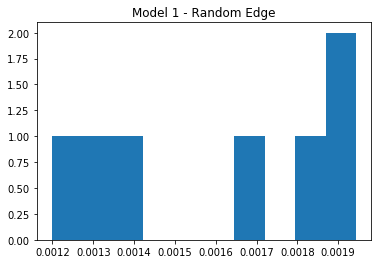

In [23]:
plt.hist(D1)
plt.title("Model 1 - Random Edge")
#因為沒有跑完結果所以分佈會很奇怪

Text(0.5, 1.0, 'Model 2 - Edge Swapping')

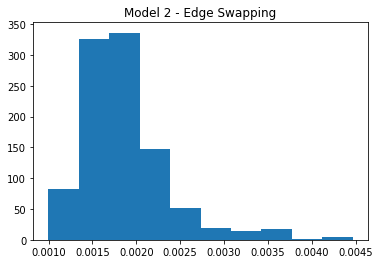

In [25]:
plt.hist(D2)
plt.title("Model 2 - Edge Swapping")

Text(0.5, 1.0, 'Model 2 - Label Swapping')

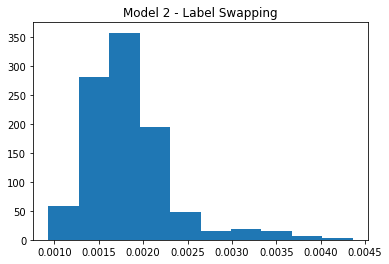

In [30]:
plt.hist(D3)
plt.title("Model 2 - Label Swapping")